# Выбор локации для скважины

Необходимо определить, где бурить новую скважину.

нам предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Построим модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируем возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

## Загрузка и подготовка данных

In [53]:
import pandas as pd
import numpy as np
from scipy import stats as st
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score

Введем данные о трех регионах.

In [54]:
data0 = pd.read_csv('/datasets/geo_data_0.csv')
data1 = pd.read_csv('/datasets/geo_data_1.csv')
data2 = pd.read_csv('/datasets/geo_data_2.csv')

In [55]:
data0.head()

,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647


In [56]:
data0.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
id         100000 non-null object
f0         100000 non-null float64
f1         100000 non-null float64
f2         100000 non-null float64
product    100000 non-null float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


В нулевом регионе представленно 100000 объектов и 5 столбцов, один из которых `id` содержит индексы скважин, 3 параметры скважины `f0`, `f1`, `f2` и оставшийся столбец содержит данные об объеме запасов.

In [57]:
data1.head()

,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305


In [58]:
data1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
id         100000 non-null object
f0         100000 non-null float64
f1         100000 non-null float64
f2         100000 non-null float64
product    100000 non-null float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


В первом регионе все тоже самое, что и в нулевом.

In [59]:
data2.head()

,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746


In [60]:
data2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
id         100000 non-null object
f0         100000 non-null float64
f1         100000 non-null float64
f2         100000 non-null float64
product    100000 non-null float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


Во втором картина аналогична нулевому и первому региону.

Для построения модели необходимо удалить столбцы с индексами, так как они будут мешать обучению.

In [61]:
data0 = data0.drop(['id'], axis=1)
data1 = data1.drop(['id'], axis=1)
data2 = data2.drop(['id'], axis=1)

Напишем функцию для оценки корреляции признаков и целевым.

In [62]:
def hists(data):
    columns = data.columns
    print(data.corr())
    for col in columns:
        data.hist(col, bins=100)

Регион 0
               f0        f1        f2   product
f0       1.000000 -0.440723 -0.003153  0.143536
f1      -0.440723  1.000000  0.001724 -0.192356
f2      -0.003153  0.001724  1.000000  0.483663
product  0.143536 -0.192356  0.483663  1.000000


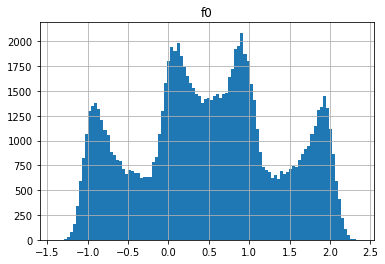

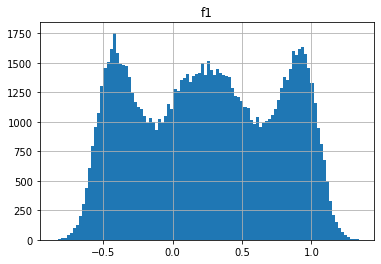

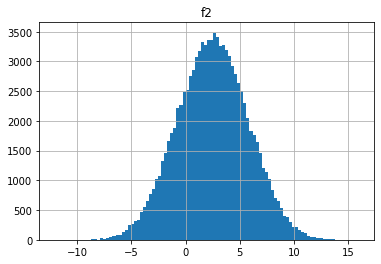

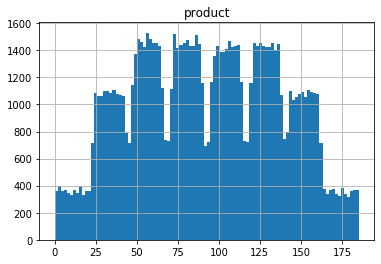

In [63]:
print('Регион 0')
hists(data0)

Признаки f0, f1 и f2 не имеют устойчивой линейной связи с целевым признаком product. Гистограммы строились, чтобы понять содержат ли данные выбросы, но все что удалось установить это то, что f0 и f1 имеют среднюю обратную связь.

Регион 1
               f0        f1        f2   product
f0       1.000000  0.182287 -0.001777 -0.030491
f1       0.182287  1.000000 -0.002595 -0.010155
f2      -0.001777 -0.002595  1.000000  0.999397
product -0.030491 -0.010155  0.999397  1.000000


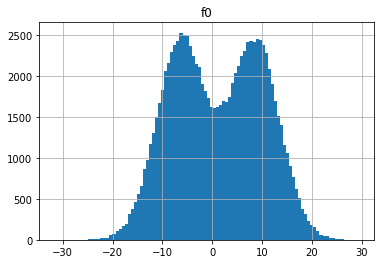

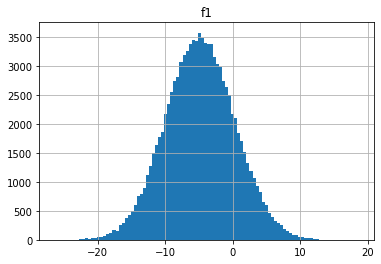

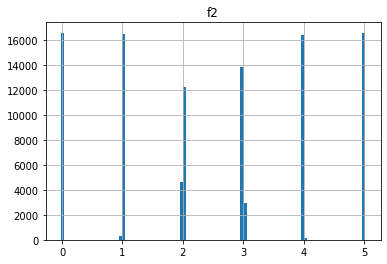

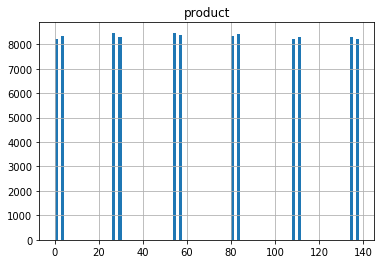

In [64]:
print('Регион 1')
hists(data1)

Признак f3 имеет прямую линейную связь с целевым признаком product. Но так как не понятно, что записано в столбце f3, нельзя говорить об утечке данных в целевом признаке наверняка. Поэтому примем тот факт, что по признаку f3 можно явно предсказать значения product.

Регион 2
               f0        f1        f2   product
f0       1.000000  0.000528 -0.000448 -0.001987
f1       0.000528  1.000000  0.000779 -0.001012
f2      -0.000448  0.000779  1.000000  0.445871
product -0.001987 -0.001012  0.445871  1.000000


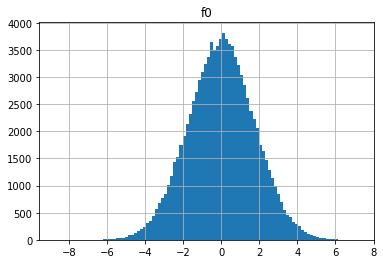

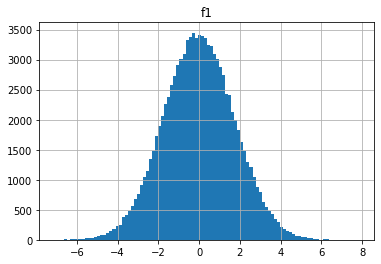

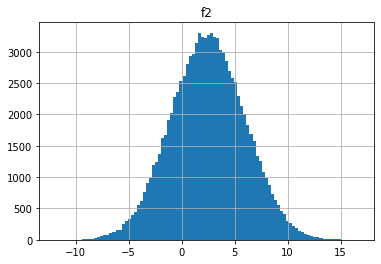

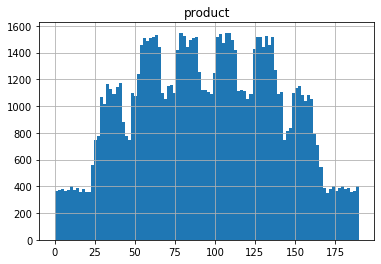

In [65]:
print('Регион 2')
hists(data2)

Признаки f0, f1 и f2 не имеют устойчивой линейной связи с целевым признаком product.

### Вывод

Данные представляли собой 3 таблицы по 5 строк и по 100000 строк. Было принято решение удалить столбец id, чтобы избавиться от названий, которые не должны влиять на предсказания модели.

## Обучение и проверка модели

Напишем функцию, которая будет принимать на вход таблицу с данными и на основе этих данных будет обучать линейную регрессию. За целевой признак принят объем запасов product, а за остальные признаки все остальные столбцы. Выборки разделены на валидационную и тренировачную в отношении 25:75. Так же функция выполнаяет масштабирование перед обучением по тренировочной выборке признаков. После обучения получаем предсказания целевого признака по валидационным признакам и сохраняем данные в dataframe с истинными значениями целевого признака и предсказанного. Возвращает функция этот dataframe.

In [66]:
def learning(data):
    target = data['product']
    features = data.drop('product', axis=1)
    features_train, features_valid, target_train, target_valid = train_test_split(
        features, target, test_size=0.25, random_state=123)

    scaler = StandardScaler()
    scaler.fit(features_train)

    features_train = pd.DataFrame(scaler.transform(features_train), index=target_train.index)
    features_valid = pd.DataFrame(scaler.transform(features_valid), index=target_valid.index)

    model = LinearRegression()
    model.fit(features_train, target_train)
    predictions = model.predict(features_valid)
    valid = pd.DataFrame({'real' : target_valid,
                          'predict' : predictions})
    print('Средний запас предсказанного сырья: {:.2f}'.format(valid['predict'].mean()))
    rmse = mean_squared_error(valid['real'], valid['predict']) ** 0.5
    print('RMSE модели: {:.2f}'.format(rmse))
    r2 = r2_score(valid['real'], valid['predict'])
    print('R2: {:.2f}'.format(r2))
    return valid

In [67]:
valid0 = learning(data0)
valid0.head()

Средний запас предсказанного сырья: 92.55
RMSE модели: 37.65
R2: 0.28


,real,predict
42083,145.825972,123.284256
71825,134.020212,75.838240
99535,88.905826,55.526760
47879,19.508226,86.673045
36734,108.713468,109.909327


In [68]:
valid1 = learning(data1)
valid1.head()

Средний запас предсказанного сырья: 69.28
RMSE модели: 0.90
R2: 1.00


,real,predict
42083,57.085625,56.056314
71825,80.859783,81.589811
99535,53.906522,54.461926
47879,107.813044,108.660979
36734,53.906522,54.479416


In [69]:
valid2 = learning(data2)
valid2.head()

Средний запас предсказанного сырья: 95.10
RMSE модели: 40.13
R2: 0.19


,real,predict
42083,147.451978,94.075161
71825,128.711794,122.604414
99535,106.628185,80.055039
47879,128.787131,100.175906
36734,159.328488,89.804044


### Вывод

Метрики обучения моделей показывают, что модель перого региона выдает идеальные результаты с R2=1 и RMSE близким к 0. Нулевой и второй регионы показывают схожие результаты, которые далеки от идеальных: R2 < 0.3 и RMSE велико.

## Подготовка к расчёту прибыли

In [70]:
points = 500 # количество скважин
points_best = 200 # количество лучших скважин
budget = 10 ** 10 # бюджен разработки на регион 10 млрд.
profit_per_one = 450000 # прибыль единицы объема из столбца product
state = np.random.RandomState(123)

Расчет необходимого объема для безубыточной разработки скважины.

In [71]:
product_nessesary = round(budget / profit_per_one / points_best, 2)
print('Для получения прибыли необходим объем запасов в скважине равный', product_nessesary)

Для получения прибыли необходим объем запасов в скважине равный 111.11


In [72]:
def comparison(data, nes):
    print('Необходим объем:', nes)
    comp = round(data['real'].mean(), 2)
    print('Средний объем:', comp)
    if nes < comp:
        print('В среднем скважина принесет прибыль')
    else:
        print('В среднем скважина убыточна')

Оценка регионов по средним объемам.

In [73]:
num = 0
for df in [valid0, valid1, valid2]:
    print('Регион', num)
    comparison(df, product_nessesary)
    num += 1
    print('----------------')

Регион 0
Необходим объем: 111.11
Средний объем: 92.85
В среднем скважина убыточна
----------------
Регион 1
Необходим объем: 111.11
Средний объем: 69.27
В среднем скважина убыточна
----------------
Регион 2
Необходим объем: 111.11
Средний объем: 94.87
В среднем скважина убыточна
----------------


### Вывод

Если разрабатывать все скважины в регионе, то это принесет лишь убытки. Необходимо выбрать лучшие скважины по объему запасов и таким образом определить регион разработки. Пока только лишь из оценки среднего объема в скважинах самым перспективным будет второй регион.

## Расчёт прибыли и рисков 

Напишем функцию для максимизации прибыли. На вход она получает данные с истинными значениями объема в скважинах и предсказаниями модели. Из предсказаных 100000 значений объема функция выбирает 500 случайных значений и из них оставляет 200 наибольших. Далее функция берет индексы этих предсказанных значений и находит по ним истинные значения объема и подсчитывает числую прибыль. Возвращает функция прибыль.

In [74]:
def profit_max(data):
    pred = data['predict']
    target = data['real']
    pred_sampled = (pred
                    .sample(n=500, replace=True, random_state=state)
                    .sort_values(ascending=False)[:200]
                   )
    target_sampled = target.loc[pred_sampled.index]
    target_sampled_sum = target_sampled.sum()
    profit = round(target_sampled_sum * profit_per_one - budget)
    return profit

Пример работы  функции.

In [75]:
num = 0
for df in [valid0, valid1, valid2]:
    print('Регион', num)
    print('Чистая прибыль:', profit_max(df))
    num += 1
    print('----------------')

Регион 0
Чистая прибыль: 254842225
----------------
Регион 1
Чистая прибыль: 404912489
----------------
Регион 2
Чистая прибыль: 484134738
----------------


Напишем функцию для того, чтобы выполнить метод bootstrap для оценки распределения прибыльности регионов. В ней мы получим 1000 вариантов прибыли в каждом из регионов. Функция вернет среднее этого распределения, доверительных 95% интервал и оценку риска разработки региона.

In [76]:
def bootstrap(data):
    non_profit_count = 0
    values = []
    for i in range(1000):
        point = profit_max(data)
        if point < 0:
            non_profit_count += 1
        values.append(point)
    values = pd.Series(values)
    profit_mean = values.mean()
    confidence_interval = st.t.interval(0.95, len(values)-1, profit_mean, values.sem())
    risk = round(non_profit_count / len(values) * 100, 2)
    return profit_mean, confidence_interval, risk

In [77]:
num = 0
for df in [valid0, valid1, valid2]:
    print('Регион', num)
    profit_mean, confidence_interval, risk = bootstrap(df)
    print('Средняя прибыль:', profit_mean)
    print('95% Доверительный интервал:', confidence_interval)
    print('Риск убытков:', risk, '%')
    num += 1
    print('----------------')

Регион 0
Средняя прибыль: 477282175.947
95% Доверительный интервал: (460923022.7942827, 493641329.0997174)
Риск убытков: 4.1 %
----------------
Регион 1
Средняя прибыль: 467598973.591
95% Доверительный интервал: (455012952.5784911, 480184994.60350895)
Риск убытков: 1.0 %
----------------
Регион 2
Средняя прибыль: 361684855.52
95% Доверительный интервал: (345001596.3378272, 378368114.70217276)
Риск убытков: 8.9 %
----------------


### Вывод

Для разработки подходят регионы с процентов риска не превышающим 2.5%. В нашем случае под этот критерий подошел только **Регион 1** с риском убытков 1%. Прибыль в регионе оценим в среднем в 467 миллионов рублей и 95% шансом получиль прибыль не меньше 455 миллионов и не больше 480 миллионов.

Для разработки предложен Регион 1.